First time use / Primeira utilização

Menu: Terminal -> New Terminal

    pip install -r requirements.txt

Online with [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/joaquimrcarvalho/cipf-comtrade.git/main?labpath=comtrade-api.ipynb):
https://mybinder.org/v2/gh/joaquimrcarvalho/cipf-comtrade.git/main?labpath=comtrade-api.ipynb




# Teste da API UN Comtrade

> The UN COMTRADE is the largest depository of international trade data. It contains well over 5 billion data records since 1962 and is available publicly on the internet. In addition, it offers public and premium data API for easier integration/download.

Informação geral: https://unstats.un.org/wiki/display/comtrade/What+is+UN+Comtrade

API Site: https://comtradedeveloper.un.org 
API specs: https://comtradedeveloper.un.org/api-details#api=comtrade-v1&operation=get-get


Manual metodológico: https://comtrade.un.org/data/MethodologyGuideforComtradePlus.pdf



## Descrições dos códigos HS

Obter tabela em https://github.com/datasets/harmonized-system/blob/master/data/harmonized-system.csv

Copiar para directoria `support`


### Ler a tabela e criar dicionários para descodificação

In [1]:
import pandas as pd

hs_codes_df = pd.read_csv('support/harmonized-system.csv') # read table
hs_codes_map = dict(zip(hs_codes_df.hscode, hs_codes_df.description)) #  dict for decoding
hs_codes_l2 = hs_codes_df[hs_codes_df.level == 2]  # create subset of level 2 codes
hs_l2_map = dict(zip(hs_codes_l2.hscode, hs_codes_l2.description)) # dict for decodung


### Obter os códigos de países e regiões

Ver lista em https://unstats.un.org/wiki/display/comtrade/Country+Code

Em formato JSON disponível em:
 * https://comtrade.un.org/data/cache/reporterAreas.json
 * https://comtrade.un.org/data/cache/partnerAreas.json

Aqui descarregamos e guardamos em `support` para evitar
ligação próxima vez.


In [2]:
import os
import json
import requests
import pandas as pd

fname = 'support/reporter_codes.json'
if os.path.isfile(fname):
    with open(fname) as cached:
        reporter_codes = json.load(cached)
else:
    resp = requests.get("https://comtrade.un.org/data/cache/reporterAreas.json")
    codes = json.loads(resp.content)['results']
    reporter_codes = dict([(a['id'], a['text'])  for a in codes])
    with open(fname, mode="x") as outfile:
        json.dump(reporter_codes,outfile,indent=2)

fname = 'support/partner_codes.json'
if os.path.isfile(fname):
    with open(fname) as cached:
        partner_codes = json.load(cached)
else:
    resp = requests.get("https://comtrade.un.org/data/cache/partnerAreas.json")
    codes = json.loads(resp.content)['results']
    partner_codes = dict([(a['id'], a['text'])  for a in codes])
    with open(fname,mode="x") as outfile:
        json.dump(reporter_codes,outfile,indent=2)

# convert codes to int
m49_reporter_codes_map = { int(k):v for (k,v) in reporter_codes.items() if k!='all'}
m49_partner_codes_map = { int(k):v for (k,v) in partner_codes.items() if k!='all'}
m49_reporter_list = ",".join(map(str,m49_reporter_codes_map.keys()))
m49_partner_list = ",".join(map(str,m49_partner_codes_map.keys()))

Os dados devolvidos pela API incluem códigos no campo `Partner2` que não estão na lista oficial de códigos M49.

Outros utilizadores têm o mesmo problema.

Ver  https://rstudio-pubs-static.s3.amazonaws.com/92321_70509e47e7f041e68f383253cb85751b.html onde se encontra o resultado de cruzamentos dos códigos dos dados e várias versões da lista
M49 e que é útil para completar a lista da FAO.

Ver também esta nota da unstats: https://unstats.un.org/wiki/display/comtrade/Reporter+country+codes+and+their+customs+areas

__Códigos atualmente em falta:__
* __473__ China-Angola Import 2016 partner2Code.
* __899__ Portugal-Angola 2018


In [3]:
reporter_codes.get(473,"Not found")

'Not found'

## Obter os dados de comtrade.un.org

### Parâmetros gerais que não mudam



In [4]:
m49_angola = 24
m49_brazil = 76
m49_cabo_verde = 132
m49_china = 156
m49_hong_kong = 344
m49_macau = 446
m49_guine_equatorial = 226
m49_guine_bissau = 624
m49_mozambique = 508
m49_portugal = 620
m49_stome_principe = 678
m49_timor = 626

# make list of Portuguese Speaking Countries
m49_plp = [m49_angola,m49_brazil,m49_cabo_verde,m49_guine_bissau,
            m49_guine_equatorial,m49_mozambique,m49_portugal,
            m49_stome_principe,m49_timor]
m49_plp_list = ",".join(map(str,m49_plp))




### Função auxiliar para aceder à API un.comtrade


In [5]:
import os
import configparser
import re
import warnings
import json
import requests
import pandas as pd

from typing import Union

fname = 'config.ini'

APIKEY = None
if os.path.isfile(fname):

    config = configparser.ConfigParser()
    config.read('config.ini')
    APIKEY = config['comtrade']['key']


baseUrl_preview = "https://comtradeapi.un.org/public/v1/preview/"
baseUrl_api = "https://comtradeapi.un.org/data/v1/get/"

if APIKEY is None:
    baseUrl = baseUrl_preview
else:
    baseUrl = baseUrl_api



def call_uncomtrade(typeCode: str, freqCode: str, 
                    reporterCode: str = '49', 
                    partnerCode: str = '024,076,132,226,624,508,620,678,626',
                    partner2Code: str = '0',
                    period: str = None,
                    clCode: str = "HS",
                    cmdCode: str = "TOTAL",
                    flowCode: str = "M,X",
                    timeout: int = 10,
                    echo_url: bool = False
                    )-> Union[pd.DataFrame,None]:
    """ Makes a request to UN Comtrade API (public), returns a pandas DataFrame
    
    Parameters
        typeCode: required, C for commodities, S for Services
        freqCode: required, A for annual and M for monthly
        reporterCode: optional, list of M49 codes, default "049" (China)
        partnerCode: optional, list of M49 codes None for all countries, default PLP codes
        partner2Code: optional, list of M49 codes, None for all countries, 0 for agregate, default 0
        period:  optional, aaaa or aaaamm default None (all available periods)
        clCode: Trade classifications: HS, SITC, BEC or EBOPS.
                Available values : HS, SS, B4, B5, EB, EB10, EB02, EBSDMX
        cmdCode: optional, default, "TOTAL"
        flowCode: optional, M=import, X=export,more: RX, RM, MIP, XIP, MOP, XOP, MIF, XIF, DX, FM; default "M,X"
        timeOut: int, max wait time in seconds. Default 10
        echo_url: bool, print url of call, default False
     """
    requestUrl=f"{baseUrl}/{typeCode}/{freqCode}/{clCode}"
    resp = requests.get(requestUrl,
            {
            'reporterCode':reporterCode,
            'period':period,
            'partnerCode':partnerCode,
            'partner2Code':partner2Code,
            'cmdCode':cmdCode,
            'flowCode':flowCode,
            'subscription-key':APIKEY
            },
            timeout=timeout)
    if echo_url:
        sanitize = re.sub("subscription-key=.*","subscription-key=HIDDEN",resp.url)
        print(sanitize)
    if resp.status_code != 200:
        warnings.warn(f"Server returned "+str(resp.status_code),)        
        warnings.warn(str(resp.content))
        df = None
        
    results = json.loads(resp.content)['data']
    if len(results) == 0:
        warnings.warn("Pesquisa não obteve resultados")
        df = None
    else:
        df = pd.DataFrame(results)

        # Convert the country codes to country names
        df.reporterDesc = df.reporterCode.map(m49_reporter_codes_map)
        df.partnerDesc = df.partnerCode.map(m49_partner_codes_map)
        df.partner2Desc = df.partner2Code.map(m49_partner_codes_map)
        # Convert the HS codes
        df.cmdDesc = df.cmdCode.map(hs_codes_map)
        # Generate a formated version of the value for readability here
        df['primaryValueFormated'] = df.primaryValue.map('{:,}'.format)
        # return the DataFrame
    return df

## Parâmetros para visualização

Definir as colunas a visualizar, ordem das linhas abaixo para simplificar
posterior visualização dos dados.

Para a lista de todas as colunas disponíveis com uma breve
descrição ver: https://unstats.un.org/wiki/display/comtrade/New+Comtrade+FAQ+for+First+Time+Users?preview=/125141443/135004360/ComtradePlus%20-%20data%20items%20-%2017%20Mar%202020.xlsx



In [6]:
# Colunas mais interessantes do resultado
# escolher de 
#        'typeCode', 'freqCode', 'refPeriodId', 'refYear', 'refMonth',
#        'period', 'reporterCode', 'reporterISO', 'reporterDesc',
#        'flowCode', 'flowDesc', 'partnerCode', 'partnerISO', 'partnerDesc',
#        'partner2Code', 'partner2ISO', 'partner2Desc',
#        'classificationCode', 'classificationSearchCode',
#        'isOriginalClassification', 'cmdCode', 'cmdDesc', 'aggrLevel',
#        'isLeaf', 'customsCode', 'customsDesc', 'mosCode', 'motCode',
#        'motDesc', 'qtyUnitCode', 'qtyUnitAbbr', 'qty', 'isQtyEstimated',
#        'altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'isAltQtyEstimated',
#        'netWgt', 'isNetWgtEstimated', 'grossWgt', 'isGrossWgtEstimated',
#        'cifvalue', 'fobvalue', 'primaryValue', 'legacyEstimationFlag',
#        'isReported', 'isAggregate', 'primaryValueFormated']

cols = ['typeCode','freqCode','reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear','cmdCode','cmdDesc','flowCode','isReported','primaryValueFormated','primaryValue']
sort_order = ['reporterDesc','partnerDesc','refYear','refMonth']

## Notas de utilização

### Partner2

O `partner2` é uma novidade dos dados comtrade. Procura registar o país de "consignação".

No caso das importações é o país que despachou os bens para o país que importa,
sem que tenham ocorrido entre o país de origem (_partner_) nenhuma transação
que modifique o estatuto legal (denominação de origem?) dos bens:

> The country of consignment in the case of imports is the country from which goods
 were dispatched to the importing country, without any commercial transactions 
 or other operations that change the legal status of the goods taking 
 place in any intermediate country.


Se a pesquisa não especifica partner2Code, alguns anos produzem mais do que uma linha por par _reporter/partner_  
com diferentes valores. Por exemplo, se a China for o `reporter` e a Guiné Equatorial o `partner` nos anos 2015, 2016, 2017 aparece::
* Uma linha por `partner2Code`, incluindo uma linha em que o `partner2` é igual ao `partner` (importações diretas).
* Uma linha adicional com `partner2Code` igual a zero que contém o total agregado das outras linhas com `partner2Code` explícito.
* Isso significa que existe duplicação do total.
  
|    | reporterDesc   | partnerDesc       |   partner2Code | partner2Desc         |   refYear | cmdCode   | flowCode   | primaryValueFormated   |
|---:|:---------------|:------------------|---------------:|:---------------------|----------:|:----------|:-----------|:-----------------------|
|  3 | China          | Equatorial Guinea |            344 | China, Hong Kong SAR |      2015 | TOTAL     | M          | 59.0                   |
|  1 | China          | Equatorial Guinea |             56 | Belgium              |      2015 | TOTAL     | M          | 2,435.0                |
|  2 | China          | Equatorial Guinea |            226 | Equatorial Guinea    |      2015 | TOTAL     | M          | 1,166,493,970.0        |
|  0 | China          | Equatorial Guinea |              0 | nan                  |      2015 | TOTAL     | M          | 1,166,496,464.0        |


Para evitar isso tem de se chamar a API com partner2Code = 0, para que os resultados de 2015,2016,2017 excluam
a decomposição. Se partner2Code=None as linhas adicionais aparecem.


Exemplo de resultados se o `partner2Code` for None.

Alterar as variáveis seguintes para testar.


In [7]:
period = "2016" ## if freqCode M  use aaaamm
flow = "X"
cmdCode = 'TOTAL'
reporterCode = m49_china
partnerCode = m49_cabo_verde

In [9]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '${:,.2f}'.format

cols_partner2 = ['reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear',
        'flowCode','primaryValue','isAggregate']
cols_partner2_qty_weight = ['reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear','cmdDesc',
        'flowCode','primaryValueFormated','primaryValue',
        'qtyUnitCode','qty','isQtyEstimated','altQtyUnitCode', 'altQtyUnitAbbr', 'altQty', 'isAltQtyEstimated',
       'netWgt', 'isNetWgtEstimated', 'grossWgt', 'isGrossWgtEstimated',
        'motCode']


df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=reporterCode,
                     partnerCode=partnerCode,
                     partner2Code=None,
                     cmdCode=cmdCode,
                     period=period,
                     timeout=30, echo_url=True
                     )
result = df.sort_values(['partner2Desc','primaryValue'], ascending=[True,False])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2016&partnerCode=132&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
1,China,Cabo Verde,132,Cabo Verde,2016,X,"$48,602,407.00",True
2,China,Cabo Verde,344,"China, Hong Kong SAR",2016,X,"$69,027.00",True
3,China,Cabo Verde,842,USA,2016,X,$4.00,True
0,China,Cabo Verde,0,NaN,2016,X,"$48,671,438.00",True


Gravar em Excel (nome do ficheiro automaticamente reflecte o valor das variáveis relevantes)

In [12]:
result.to_excel(f"./downloads/partner2_{m49_reporter_codes_map[reporterCode]}_{m49_reporter_codes_map[partnerCode]}_{flow}_{period}.xlsx")

A função `call_uncomtrade` passou a colocar `partner2Code = 0` quando não especificado,
para evitar o problema.

Neste exemplo não se inclui o parâmetro `partner2Code` e a função coloca a zero para obter o resultado
correcto.

In [10]:
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     cmdCode='TOTAL',
                     period=period,
                     timeout=60,
                     echo_url=True
                     )
result = df.sort_values(['partnerDesc','flowCode'])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2016&partnerCode=132&partner2Code=0&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
0,China,Cabo Verde,0,NaN,2016,X,"$48,671,438.00",True


Não parece ser possível obter as informações referentes a partner2
 senão nos anos 2015-2017, quando o `reporter` é a China.

In [11]:
period2 = "2017,2018,2019,2020" ## if freqCode M  use aaaamm

df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     partner2Code=None,
                     cmdCode='TOTAL',
                     period=period2,
                     timeout=None,
                     echo_url=True
                     )
result = df.sort_values(['partnerDesc','flowCode'])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2017%2C2018%2C2019%2C2020&partnerCode=132&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
0,China,Cabo Verde,0,NaN,2017,X,"$69,239,870.00",True
1,China,Cabo Verde,132,Cabo Verde,2017,X,"$68,188,881.00",True
2,China,Cabo Verde,344,"China, Hong Kong SAR",2017,X,"$1,046,532.00",True
3,China,Cabo Verde,410,Rep. of Korea,2017,X,$7.00,True
4,China,Cabo Verde,608,Philippines,2017,X,"$4,450.00",True
5,China,Cabo Verde,0,NaN,2018,X,"$78,265,751.00",True
6,China,Cabo Verde,0,NaN,2019,X,"$64,166,991.00",True
7,China,Cabo Verde,0,NaN,2020,X,"$77,836,679.00",True


Mas outros países incluem esses dados em outros anos, por exemplo, Portugal

In [12]:
period = "2018" ## if freqCode M  use aaaamm
reporterCode=m49_portugal

df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=reporterCode,
                     partnerCode=partnerCode,
                     partner2Code=None,
                     cmdCode='TOTAL',
                     period=period,
                     timeout=None,
                     echo_url=True
                     )
result = df.sort_values(['partnerDesc','flowCode'])[cols_partner2]
# print(result.to_markdown())
result

https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=620&period=2018&partnerCode=132&cmdCode=TOTAL&flowCode=X&subscription-key=HIDDEN


,reporterDesc,partnerDesc,partner2Code,partner2Desc,refYear,flowCode,primaryValue,isAggregate
0,Portugal,Cabo Verde,0,NaN,2018,X,"$321,588,644.81",True
1,Portugal,Cabo Verde,0,NaN,2018,X,"$18,277,381.32",True
2,Portugal,Cabo Verde,0,NaN,2018,X,"$302,388,689.71",True
3,Portugal,Cabo Verde,0,NaN,2018,X,"$562,513.78",True
4,Portugal,Cabo Verde,0,NaN,2018,X,"$360,060.01",True
5,Portugal,Cabo Verde,56,Belgium,2018,X,"$74,496.11",True
6,Portugal,Cabo Verde,56,Belgium,2018,X,"$1,279.87",True
7,Portugal,Cabo Verde,56,Belgium,2018,X,"$73,216.24",True
8,Portugal,Cabo Verde,251,France,2018,X,"$185,373.44",True
9,Portugal,Cabo Verde,251,France,2018,X,$644.07,True


Os dados com partner2Code de Portugal colocam outros problemas,
como o que parece ser duplicação de entradas.

## Reproduzir os dados do anuário do Forum Macau

O Forum Macau inclui desde 2016 um quadro sumário
dos dados das trocas comerciais entre a China e 
os PLP. Ver https://www.forumchinaplp.org.mo/pt/publications-data-4/annual-reports/

Aqui reproduzimos esses quadros a partir dos
dados atualmente disponíveis no UN Comtrade.

>NOTA: Tal como nos quadros do Forum os valores são
apresentados em 10 mil USD

In [14]:


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f} $10mil'.format

cols2 = ['reporterDesc','partnerDesc','partner2Code','partner2Desc','refYear','cmdCode','flowCode','primaryValueFormated']
period = "2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021" ## if freqCode M  use aaaamm
flow = "M,X"
partnerCode = m49_plp_list
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     cmdCode='TOTAL',
                     period=period,
                     timeout=30
                     )

temp=df.pivot(index=['refYear','partnerDesc',],columns='flowCode',values='primaryValue')
temp['C'] = temp['M'] + temp['X']
forum_type = temp[['C','X','M']]
forum_type.columns=['Trocas','Exportações','Importações']
forum_type.div(10000)

Trocas         Exportações  \
refYear partnerDesc                                                      
2010    Angola                 2,481,892.20 $10mil   200,387.26 $10mil   
        Brazil                 6,256,009.92 $10mil 2,446,065.19 $10mil   
        Cabo Verde                 3,434.72 $10mil     3,433.51 $10mil   
        Equatorial Guinea        105,489.83 $10mil    45,624.12 $10mil   
        Guinea-Bissau              1,329.66 $10mil       943.37 $10mil   
        Mozambique                69,746.86 $10mil    49,639.10 $10mil   
        Portugal                 326,774.37 $10mil   251,331.77 $10mil   
        Sao Tome and Principe        206.47 $10mil       205.43 $10mil   
        Timor-Leste                4,308.25 $10mil     4,283.20 $10mil   
2011    Angola                 2,770,633.39 $10mil   278,415.34 $10mil   
        Brazil                 8,422,342.76 $10mil 3,183,667.73 $10mil   
        Cabo Verde                 4,976.37 $10mil     4,975.17 $10mil   
        Equatorial Guinea        193,926.46 $10mil    26,631.71 $10mil   
        Guinea-Bissau              1,896.36 $10mil     1,485.09 $10mil   
        Mozambique                95,748.82 $10mil    70,024.70 $10mil   
        Portugal                 396,349.77 $10mil   280,143.37 $10mil   
        Sao Tome and Principe        179.38 $10mil       179.22 $10mil   
        Timor-Leste                7,217.56 $10mil     7,043.28 $10mil   
2012    Angola                 3,760,106.82 $10mil   403,917.13 $10mil   
        Brazil                 8,569,476.01 $10mil 3,341,363.33 $10mil   
        Cabo Verde                 5,749.16 $10mil     5,749.05 $10mil   
        Equatorial Guinea        218,423.75 $10mil    36,143.42 $10mil   
        Guinea-Bissau              2,252.81 $10mil     1,589.46 $10mil   
        Mozambique               134,420.75 $10mil    94,088.70 $10mil   
        Portugal                 401,573.96 $10mil   250,115.76 $10mil   
        Sao Tome and Principe        305.06 $10mil       300.76 $10mil   
        Timor-Leste                6,316.17 $10mil     6,247.35 $10mil   
2013    Angola                 3,593,672.83 $10mil   396,405.89 $10mil   
        Brazil                 9,019,459.39 $10mil 3,589,547.12 $10mil   
        Cabo Verde                 6,199.63 $10mil     6,199.61 $10mil   
        Equatorial Guinea        282,743.52 $10mil    35,751.72 $10mil   
        Guinea-Bissau              2,871.73 $10mil     1,188.96 $10mil   
        Mozambique               165,416.80 $10mil   119,929.32 $10mil   
        Portugal                 390,632.45 $10mil   250,686.37 $10mil   
        Sao Tome and Principe        486.45 $10mil       486.20 $10mil   
        Timor-Leste                4,778.34 $10mil     4,738.64 $10mil   
2014    Angola                 3,708,101.19 $10mil   597,499.68 $10mil   
        Brazil                 8,654,335.94 $10mil 3,489,013.45 $10mil   
        Cabo Verde                 5,122.65 $10mil     5,122.34 $10mil   
        Equatorial Guinea        356,970.56 $10mil    35,251.53 $10mil   
        Guinea-Bissau              6,710.94 $10mil     1,715.32 $10mil   
        Mozambique               361,856.21 $10mil   196,873.98 $10mil   
        Portugal                 480,036.47 $10mil   313,707.32 $10mil   
        Sao Tome and Principe        572.82 $10mil       572.77 $10mil   
        Timor-Leste                6,044.15 $10mil     6,034.16 $10mil   
2015    Angola                 1,971,875.73 $10mil   371,714.59 $10mil   
        Brazil                 7,150,158.35 $10mil 2,741,222.54 $10mil   
        Cabo Verde                 4,332.28 $10mil     4,330.02 $10mil   
        Equatorial Guinea        142,788.64 $10mil    26,138.99 $10mil   
        Guinea-Bissau              3,529.51 $10mil     1,748.27 $10mil   
        Mozambique               239,063.94 $10mil   193,802.34 $10mil   
        Portugal                 435,646.62 $10mil   289,492.31 $10mil   
        Sao Tome and Principe        599.00 $10m

### Gravar em Excel

In [17]:
forum_type.to_excel(f"./downloads/quadros_forum_{period.replace(',','_')}.xlsx")
forum_type.div(10).to_excel(f"./downloads/quadros_forum_10_{period.replace(',','_')}.xlsx")
forum_type.div(10000).to_excel(f"./downloads/quadros_forum_10mil_{period.replace(',','_')}.xlsx")

### Gráficos dos dados formato Forum Macau

In [18]:
pd.options.display.float_format = '{:,.2f}'.format
movimento = 'Trocas' # Trocas, Importações, Exportações
graph_data = forum_type.reset_index().pivot(index='refYear',columns=['partnerDesc'], values=[movimento])
graph_data.columns.set_names(['Movimento','Parceiro'], inplace=True)
graph_data

Movimento            Trocas                                   \
Parceiro             Angola             Brazil    Cabo Verde   
refYear                                                        
2010      24,818,922,030.00  62,560,099,217.00 34,347,153.00   
2011      27,706,333,858.00  84,223,427,605.00 49,763,747.00   
2012      37,601,068,187.00  85,694,760,113.00 57,491,588.00   
2013      35,936,728,280.00  90,194,593,897.00 61,996,254.00   
2014      37,081,011,865.00  86,543,359,382.00 51,226,457.00   
2015      19,718,757,266.00  71,501,583,488.00 43,322,801.00   
2016      15,646,515,704.00  67,831,200,011.00 48,754,719.00   
2017      22,956,162,692.00  87,807,693,508.00 69,247,880.00   
2018      28,079,647,462.00 111,234,639,172.00 78,556,148.00   
2019      25,893,129,559.00 115,501,610,959.00 64,195,682.00   
2020      16,505,822,542.00 120,470,436,745.00 79,046,671.00   
2021      23,399,776,998.00 163,490,100,674.00 85,684,661.00   

Movimento                                                                    \
Parceiro  Equatorial Guinea Guinea-Bissau       Mozambique         Portugal   
refYear                                                                       
2010       1,054,898,266.00 13,296,570.00   697,468,565.00 3,267,743,710.00   
2011       1,939,264,554.00 18,963,628.00   957,488,225.00 3,963,497,677.00   
2012       2,184,237,487.00 22,528,109.00 1,344,207,513.00 4,015,739,555.00   
2013       2,827,435,191.00 28,717,318.00 1,654,167,987.00 3,906,324,480.00   
2014       3,569,705,576.00 67,109,419.00 3,618,562,147.00 4,800,364,696.00   
2015       1,427,886,383.00 35,295,105.00 2,390,639,408.00 4,356,466,156.00   
2016         780,105,337.00 21,397,687.00 1,787,914,668.00 5,584,937,614.00   
2017       1,650,052,982.00 34,126,721.00 1,835,461,354.00 5,584,393,468.00   
2018       2,284,518,497.00 37,470,387.00 2,495,314,478.00 5,999,253,728.00   
2019       1,836,268,508.00 40,341,038.00 2,670,936,644.00 6,688,752,834.00   
2020       1,304,669,441.00 51,436,017.00 2,579,567,171.00 6,953,053,417.00   
2021       1,339,126,559.00 88,880,025.00 4,036,732,373.00 8,808,028,463.00   

Movimento                                       
Parceiro  Sao Tome and Principe    Timor-Leste  
refYear                                         
2010               2,064,686.00  43,082,495.00  
2011               1,793,809.00  72,175,553.00  
2012               3,050,638.00  63,161,676.00  
2013               4,864,493.00  47,783,404.00  
2014               5,728,191.00  60,441,499.00  
2015               5,989,950.00 105,254,503.00  
2016               6,422,213.00 164,564,406.00  
2017               6,902,568.00 134,169,790.00  
2018               7,304,349.00 135,404,120.00  
2019               8,934,279.00 167,513,087.00  
2020              20,360,128.00 192,483,012.00  
2021              15,077,312.00 373,584,568.00

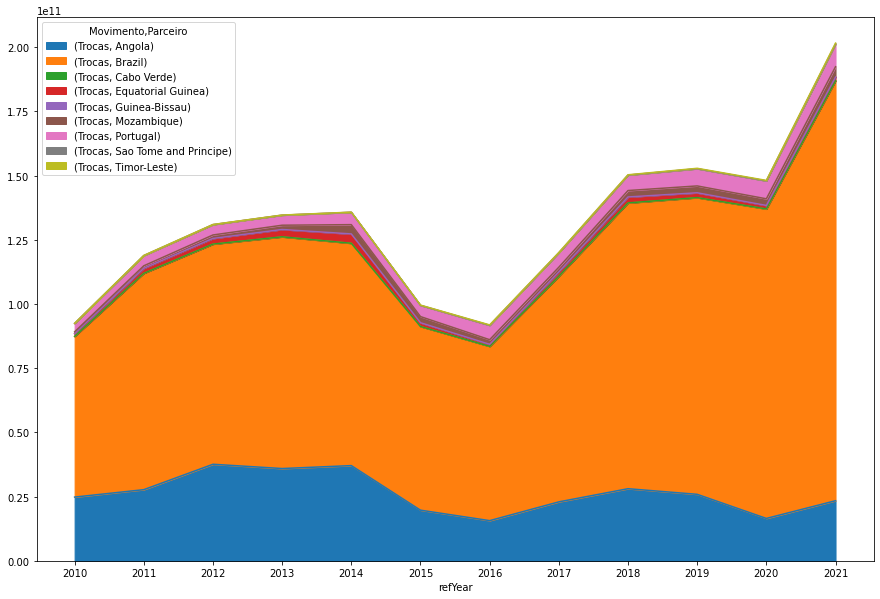

In [19]:
import matplotlib.pyplot as plt
graph_data.plot.area(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}.png")

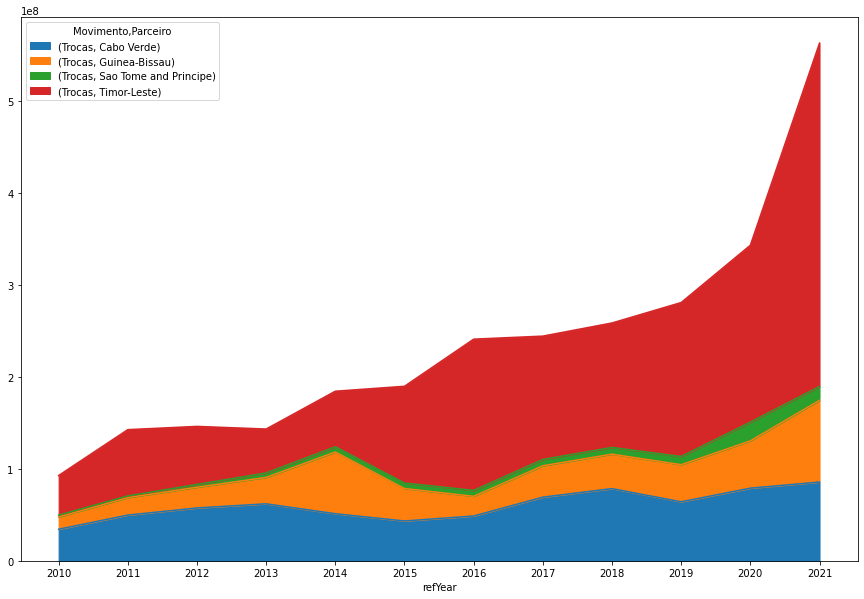

In [42]:
import matplotlib.pyplot as plt

detalhe_paises = ['Cabo Verde','Guinea-Bissau','Sao Tome and Principe','Timor-Leste']
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.area(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_cb_gb_stp_tl.png")


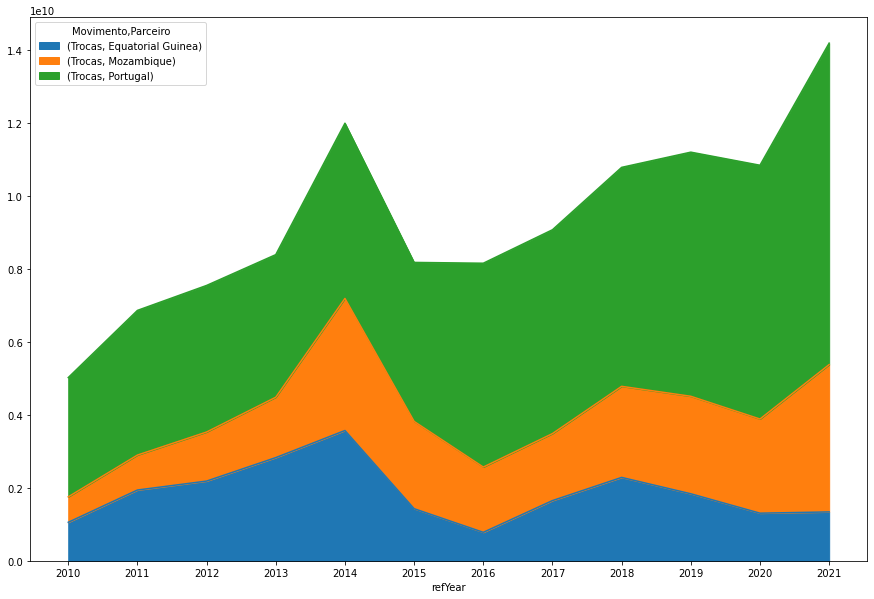

In [43]:
import matplotlib.pyplot as plt

detalhe_paises = ['Equatorial Guinea','Mozambique','Portugal',]
cols = [(movimento, pais) for pais in detalhe_paises]
graph_data[cols].plot.area(figsize=(15,10),xticks=graph_data.index.values)
plt.savefig(f"downloads/cn_plp_{movimento}_ge_mo_pt.png")

## Cobertura dos dados: importações/exportações China-PLP anos disponíveis

In [44]:
import time

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

flow = "M,X"
for country_code in m49_plp:
    df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flow,
                     reporterCode=m49_china,
                     partnerCode=country_code,
                     partner2Code=0,
                     period=None, # period None returns all the available period
                     timeout=30
                     )
    print(m49_partner_codes_map[country_code],  df.refYear.unique())
    time.sleep(1)  # avoid stressing the UN server.



Angola [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Brazil [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Cabo Verde [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Guinea-Bissau [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Equatorial Guinea [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Mozambique [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Portugal [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Sao Tome and Principe [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
Timor-Leste [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


## China, trocas mais importantes com os PLP

Obtem os totais agregados com nível 2 de código HS e lista os primeiros

In [110]:
rank_filter = 5  # número de importações mais relevantes
years = "2021"
flowCode = 'M,X'
pco_cols = ['reporterDesc','partnerDesc','refYear','rank','cmdDesc',
            'flowCode','primaryValueFormated']
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode="AG2",
                     reporterCode=m49_china,
                     partnerCode=m49_plp_list,
                     period=years,
                     timeout=60
                     )

pco = df.sort_values(['partnerDesc','refYear','primaryValue'], ascending=[True,True,False])
pco['rank'] = pco.groupby(['partnerDesc','refYear','flowCode'])["primaryValue"].rank(method="dense", ascending=False)
pco_top5 = pco[pco['rank'] <= rank_filter]
# save to Excel
filename_note=f"{years.replace(',','_')}_{flowCode.replace(',','_')}"  # change to append to filename
pco_top5.to_excel(f"./downloads/china_plp_top5_{filename_note}.xlsx")
# show
pco_top5[pco_cols].set_index(['reporterDesc','partnerDesc','refYear','flowCode']).sort_index()

rank  \
reporterDesc partnerDesc           refYear flowCode         
China        Angola                2021    M         1.00   
                                           M         2.00   
                                           M         3.00   
                                           M         4.00   
                                           M         5.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                                           X         4.00   
                                           X         5.00   
             Brazil                2021    M         1.00   
                                           M         2.00   
                                           M         3.00   
                                           M         4.00   
                                           M         5.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                                           X         4.00   
                                           X         5.00   
             Cabo Verde            2021    M         1.00   
                                           M         2.00   
                                           M         3.00   
                                           M         4.00   
                                           M         5.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                                           X         4.00   
                                           X         5.00   
             Equatorial Guinea     2021    M         1.00   
                                           M         2.00   
                                           M         3.00   
                                           M         4.00   
                                           M         5.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                                           X         4.00   
                                           X         5.00   
             Guinea-Bissau         2021    M         1.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                                           X         4.00   
                                           X         5.00   
             Mozambique            2021    M         1.00   
                                           M         2.00   
                                           M         3.00   
                                           M         4.00   
                                           M         5.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                                           X         4.00   
                                           X         5.00   
             Portugal              2021    M         1.00   
                                           M         2.00   
                                           M         3.00   
                                           M         4.00   
                                           M         5.00   
                                           X         1.00   
                                           X         2.00   
                                           X         3.00   
                           

## China, detalhe das exportações mais importants dos PLP para a China

Em dois passos: 
* obtém as categorias de nível 2 mais importantes de cada país
* pesquisa todos as subcategorias de cada

In [89]:
rank_filter = 5  # número de importações mais relevantes
years = "2021"
partnerCode = m49_angola # Não funciona com m49_cabo_verde, m49_guine_bissau, m49_guine_equatorial(2021)
flowCode="M"

In [90]:
pco_cols = ['reporterDesc','partnerDesc','refYear','rank','cmdDesc',
            'flowCode','primaryValueFormated']

pco_cols_detail = ['reporterDesc','partnerDesc','refYear','cmdCode','cmdDesc',
            'flowCode','primaryValue', 'isAggregate']

# first we collect the top commodity level 2 codes            
df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode="AG2",
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     period=years,
                     timeout=30
                     )

pco = df.sort_values(['partnerDesc','refYear','primaryValue'], ascending=[True,True,False])
pco['rank'] = pco.groupby(['partnerDesc','refYear'])["primaryValue"].rank(method="dense", ascending=False)
pco_top5 = pco[pco['rank'] <= rank_filter]
# get the countries
countries = pco_top5.partnerDesc.unique()
country_cmd_top5_codes = dict()

# get the detailed commodity codes for the top of each country
for country in countries:
    l2_codes = pco_top5[pco_top5.partnerDesc == country]['cmdCode'].unique()
    print(country,l2_codes)
    hs_details = []
    for l2_code in l2_codes:
        l2_sub_codes = list(hs_codes_df[hs_codes_df.hscode.str.startswith(l2_code)]['hscode'])
        hs_details = hs_details + l2_sub_codes
    # print(hs_details)
    country_cmd_top5_codes[country] = hs_details.copy()

# now we fetch the detail
countryDesc = m49_partner_codes_map[partnerCode]
country_cmd_codes = ",".join(country_cmd_top5_codes[countryDesc])
# print(country_cmd_codes)

df = call_uncomtrade("C",# C for commodities, S for Services
                     "A",# (freqCode) A for annual and M for monthly
                     flowCode=flowCode,
                     cmdCode=None, # we ignore the detail commodity codes because it generates errors
                     reporterCode=m49_china,
                     partnerCode=partnerCode,
                     partner2Code=0,
                     period=years,
                     echo_url=True,
                     timeout=60
                     )
df[pco_cols_detail].to_excel(f"./downloads/china_plp_{years}_{flowCode}_detail_{countryDesc}.xlsx")
df[df.isAggregate == False][pco_cols_detail].sort_values('primaryValue',ascending=False).head(100)

Angola ['27' '25' '26' '74' '76']
https://comtradeapi.un.org/data/v1/get//C/A/HS?reporterCode=156&period=2021&partnerCode=24&partner2Code=0&flowCode=M&subscription-key=HIDDEN


,reporterDesc,partnerDesc,refYear,cmdCode,cmdDesc,flowCode,primaryValue,isAggregate
28,China,Angola,2021,270900,Oils; petroleum oils and oils obtained from bi...,M,"19,855,580,399.00",False
31,China,Angola,2021,271112,Petroleum gases and other gaseous hydrocarbons...,M,"423,920,134.00",False
30,China,Angola,2021,271111,Petroleum gases and other gaseous hydrocarbons...,M,"305,044,314.00",False
34,China,Angola,2021,271500,"Bituminous mixtures based on natural asphalt, ...",M,"200,515,472.00",False
32,China,Angola,2021,271113,Petroleum gases and other gaseous hydrocarbons...,M,"38,813,644.00",False
13,China,Angola,2021,251612,"Granite; merely cut, by sawing or otherwise, i...",M,"16,997,045.00",False
77,China,Angola,2021,740312,"Copper; refined, unwrought, wire-bars",M,"13,144,124.00",False
12,China,Angola,2021,251611,Granite; crude or roughly trimmed,M,"12,720,535.00",False
21,China,Angola,2021,260200,"Manganese ores and concentrates, including fer...",M,"11,704,627.00",False
86,China,Angola,2021,760120,"Aluminium; unwrought, alloys",M,"9,887,820.00",False


Por ordem de importância, apenas as "folhas"

__NOTA__: nem sempre a coluna `isAggregate` tem o valor correcto, ver Angola 2016